# Problem Statement

In this competition, goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv


In [65]:
# Importng Required Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Prepration

### Load Data

In [66]:
train = pd.read_csv(r'/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv(r'/kaggle/input/digit-recognizer/test.csv')

In [67]:
y_train = train['label']
X_train=train.drop('label',axis=1)

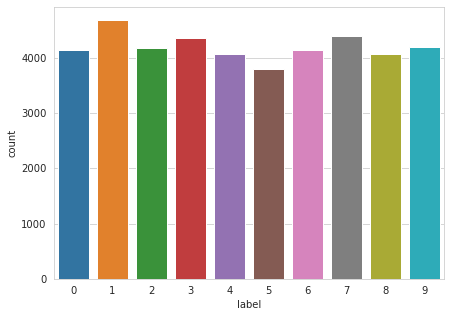

In [68]:
sns.set_style('whitegrid')
plt.figure(figsize=(7,5))
sns.countplot(y_train)

### Check for Missing Values

In [69]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [70]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### Normalization

In [71]:
X_train /= 255.0
test /= 255.0

### Reshape

In [72]:
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

### Label Encoding

In [73]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

### Split Training and Validation Set

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

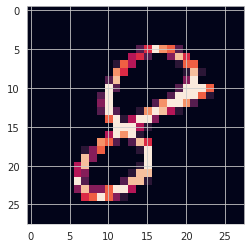

In [75]:
plt.imshow(X_train[0][:,:,0])

In [76]:
y_train.shape

(37800, 10)

## CNN

### Defining the model

In [77]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(5,5),activation='relu',padding='same',input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(5,5),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10,activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)       

### Initializing Optimizer

In [78]:
optimizer=tf.keras.optimizers.RMSprop(lr=0.001)

In [79]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

### Data Augmentation

In [80]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rotation_range=40,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest')
datagen.fit(X_train)

In [81]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001* tf.math.exp(0.1 * (10-epoch))
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [82]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=120),
                              epochs = 45, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 120
                              , callbacks=[callback])

Train for 315 steps, validate on 4200 samples
Epoch 1/45
315/315 - 17s - loss: 1.0897 - acc: 0.6442 - val_loss: 4.7526 - val_acc: 0.2176
Epoch 2/45
315/315 - 14s - loss: 0.3813 - acc: 0.8778 - val_loss: 0.1368 - val_acc: 0.9583
Epoch 3/45
315/315 - 14s - loss: 0.2724 - acc: 0.9148 - val_loss: 0.2120 - val_acc: 0.9324
Epoch 4/45
315/315 - 14s - loss: 0.2242 - acc: 0.9309 - val_loss: 0.0898 - val_acc: 0.9719
Epoch 5/45
315/315 - 14s - loss: 0.1975 - acc: 0.9380 - val_loss: 0.0806 - val_acc: 0.9776
Epoch 6/45
315/315 - 15s - loss: 0.1839 - acc: 0.9428 - val_loss: 0.1211 - val_acc: 0.9579
Epoch 7/45
315/315 - 14s - loss: 0.1657 - acc: 0.9492 - val_loss: 0.1043 - val_acc: 0.9686
Epoch 8/45
315/315 - 14s - loss: 0.1575 - acc: 0.9510 - val_loss: 0.0721 - val_acc: 0.9767
Epoch 9/45
315/315 - 14s - loss: 0.1462 - acc: 0.9547 - val_loss: 0.0662 - val_acc: 0.9774
Epoch 10/45
315/315 - 15s - loss: 0.1438 - acc: 0.9557 - val_loss: 0.0709 - val_acc: 0.9740
Epoch 11/45
315/315 - 14s - loss: 0.1372 - 

### Evaluating the Model

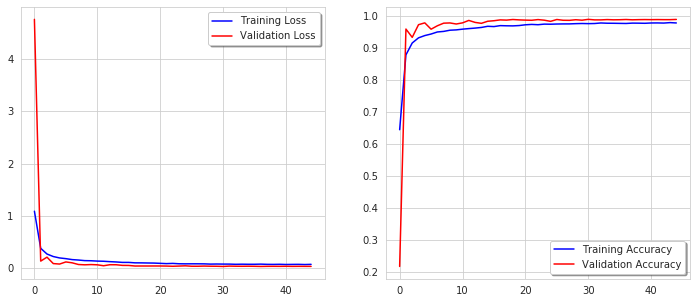

In [88]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['acc'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_acc'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)

### Confusion Matrix

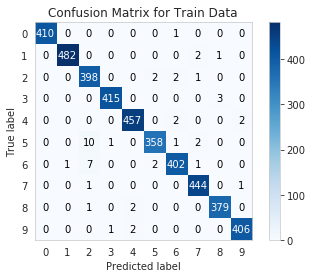

In [84]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_true,y_pred_classes,title='Confusion Matrix for Train Data')

### Predicting results on test data

In [85]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

In [86]:
submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), results], axis=1)
submission.to_csv(r'Digit_Recognizer', index=False)